In [166]:


import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import argparse
import os

import numpy as np
import pandas as pd
import seaborn as sns
from config import get_cfg_defaults
from pandas import *

from datasets.dataset_generic import DatasetGeneric

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#Load datasets

np_sigmas = [x.cpu().detach().numpy() for x in self.sigmas]
    
train_dataset = self.dataset_class(
    annotation_path =self.trainer_config.DATASET.SRC_TARGETS,
    landmarks = self.landmarks,
    LabelGenerator = self.train_label_generator,
    split = "training",
    sample_mode = self.sampler_mode,
    sample_patch_size = self.trainer_config.SAMPLER.PATCH.SAMPLE_PATCH_SIZE,
    sample_patch_bias = self.trainer_config.SAMPLER.PATCH.SAMPLER_BIAS,
    sample_patch_from_resolution = self.trainer_config.SAMPLER.PATCH.RESOLUTION_TO_SAMPLE_FROM,
    root_path = self.trainer_config.DATASET.ROOT,
    sigmas =  np_sigmas,
    generate_hms_here = not self.gen_hms_in_mainthread, 
    cv = self.fold,
    cache_data = self.trainer_config.TRAINER.CACHE_DATA,
    num_res_supervisions = self.num_res_supervision,
    debug=self.trainer_config.SAMPLER.DEBUG ,
    input_size =  self.trainer_config.SAMPLER.INPUT_SIZE,
    hm_lambda_scale = self.trainer_config.MODEL.HM_LAMBDA_SCALE,
    data_augmentation_strategy = self.trainer_config.SAMPLER.DATA_AUG,
    data_augmentation_package = self.trainer_config.SAMPLER.DATA_AUG_PACKAGE,
    dataset_split_size = self.trainer_config.DATASET.TRAINSET_SIZE,
)

if self.perform_validation:
    #if patchify, we want to return the full image
    if self.sampler_mode == "patch":            
        valid_dataset = self.get_evaluation_dataset("validation", self.trainer_config.SAMPLER.PATCH.RESOLUTION_TO_SAMPLE_FROM)
    else:
        valid_dataset = self.get_evaluation_dataset("validation", self.trainer_config.SAMPLER.INPUT_SIZE)
  self.train_dataloader = DataLoader(train_dataset, batch_size=self.data_loader_batch_size, shuffle=True)
self.valid_dataloader = DataLoader(valid_dataset, batch_size=self.data_loader_batch_size, shuffle=False )

E-CPV Uncertainty U-NET
E-CPV Uncertainty U-NET
E-CPV Uncertainty U-NET
E-CPV Uncertainty U-NET
E-CPV Uncertainty U-NET


In [219]:
print("model and UE pair: ", model, uncertainty_measure, uncertainty_localisation_er, )
print("lenght of x and y", len(train_x), len(train_y))

print("uncertainties: ", train_x)
print("errors: ", train_y)

# f, ax = plt.subplots(1, 2, figsize=(16, 16))


# ax[0].hist(train_x, bins=10)  # density=False would make counts
# # ax[0].ylabel('Probability')
# # ax[0].xlabel('Uncertianty')

# ax[1].hist(train_y, bins=10)  # density=False would make counts
# # ax[1].ylabel('Probability')
# # ax[1].xlabel('Error')
# plt.show()


model and UE pair:  U-NET E-CPV Uncertainty E-CPV Error
lenght of x and y 60 60
uncertainties:  tensor([ 8.3948,  2.5153, 11.3970,  6.4915,  6.2589,  4.0105,  5.1090,  4.8883,
         9.8772,  3.6327,  3.5903, 31.8362,  3.5844,  3.0264,  4.4894,  6.8863,
         4.5751,  5.0890,  5.1546,  4.0833,  5.3941,  8.3166,  4.4632,  4.5780,
         5.3237,  4.7034,  3.5097,  4.3403,  4.9086,  6.0680,  3.7359,  3.6298,
         4.3127,  5.3404,  3.2652,  6.4149,  5.9906,  4.0833,  6.3601,  5.6271,
         4.0517, 12.4115,  3.9416,  2.5663,  3.9103,  4.9556,  4.9929,  6.1519,
         4.6582,  7.6448,  5.4889, 14.0836,  7.6391,  3.2735,  4.4176,  3.2187,
         2.9023,  6.5153,  7.7358,  4.8765], dtype=torch.float64)
errors:  tensor([11.0454,  8.4853,  6.0828,  7.2801, 13.3417, 10.8167,  7.2801,  8.2462,
        10.2956, 19.2094,  4.2426, 15.6205, 10.4403,  3.1623,  9.0554,  6.0828,
        17.4929, 10.2956, 35.6931, 10.6301, 11.1803,  7.8102, 16.1245,  6.0828,
         9.4340, 10.1980, 17.

In [220]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(  gpytorch.kernels.RBFKernel() + gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [221]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 2500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f     noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        # model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 100, 100)
    observed_pred = likelihood(model(test_x))
    optimizer.step()

Iter 1/2500 - Loss: 27.549     noise: 0.693
Iter 2/2500 - Loss: 27.549     noise: 0.693
Iter 3/2500 - Loss: 27.549     noise: 0.693
Iter 4/2500 - Loss: 27.549     noise: 0.693
Iter 5/2500 - Loss: 27.549     noise: 0.693
Iter 6/2500 - Loss: 27.549     noise: 0.693
Iter 7/2500 - Loss: 27.549     noise: 0.693
Iter 8/2500 - Loss: 27.549     noise: 0.693
Iter 9/2500 - Loss: 27.549     noise: 0.693
Iter 10/2500 - Loss: 27.549     noise: 0.693
Iter 11/2500 - Loss: 27.549     noise: 0.693
Iter 12/2500 - Loss: 27.549     noise: 0.693
Iter 13/2500 - Loss: 27.549     noise: 0.693
Iter 14/2500 - Loss: 27.549     noise: 0.693
Iter 15/2500 - Loss: 27.549     noise: 0.693


/home/schobs/.conda/envs/landmark_unet/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 16/2500 - Loss: 27.549     noise: 0.693
Iter 17/2500 - Loss: 27.549     noise: 0.693
Iter 18/2500 - Loss: 27.549     noise: 0.693
Iter 19/2500 - Loss: 27.549     noise: 0.693
Iter 20/2500 - Loss: 27.549     noise: 0.693
Iter 21/2500 - Loss: 27.549     noise: 0.693
Iter 22/2500 - Loss: 27.549     noise: 0.693
Iter 23/2500 - Loss: 27.549     noise: 0.693
Iter 24/2500 - Loss: 27.549     noise: 0.693
Iter 25/2500 - Loss: 27.549     noise: 0.693
Iter 26/2500 - Loss: 27.549     noise: 0.693
Iter 27/2500 - Loss: 27.549     noise: 0.693
Iter 28/2500 - Loss: 27.549     noise: 0.693
Iter 29/2500 - Loss: 27.549     noise: 0.693
Iter 30/2500 - Loss: 27.549     noise: 0.693
Iter 31/2500 - Loss: 27.549     noise: 0.693
Iter 32/2500 - Loss: 27.549     noise: 0.693
Iter 33/2500 - Loss: 27.549     noise: 0.693
Iter 34/2500 - Loss: 27.549     noise: 0.693
Iter 35/2500 - Loss: 27.549     noise: 0.693
Iter 36/2500 - Loss: 27.549     noise: 0.693
Iter 37/2500 - Loss: 27.549     noise: 0.693
Iter 38/25

In [222]:

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 100, 1000)
    observed_pred = likelihood(model(test_x))



# f_preds = model(test_x)
# y_preds = likelihood(model(test_x))

# f_mean = f_preds.mean
# f_var = f_preds.variance
# f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape=torch.Size(1000,))


/tmp/ipykernel_2686841/1285715406.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim([0, 60])


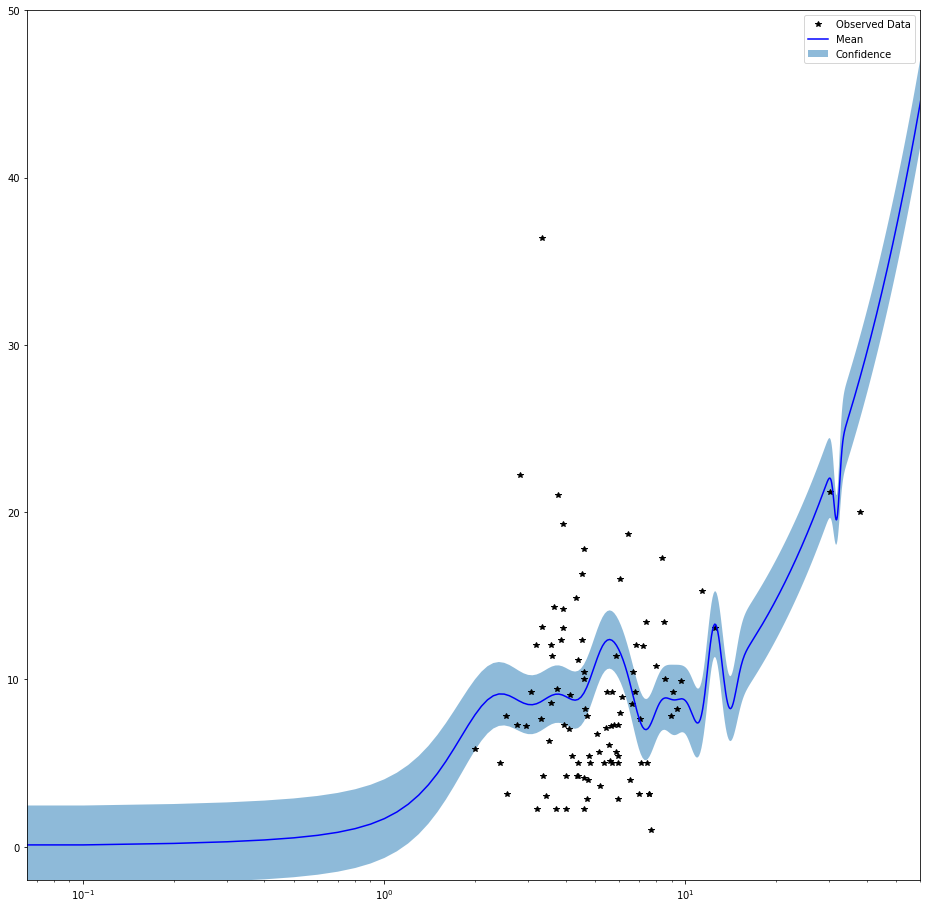

In [223]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(16, 16))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(un_test_x.numpy(), un_test_y.numpy(), 'k*')
    # ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-2, 50])
    ax.set_xscale('log')

    ax.set_xlim([0, 60])

    ax.legend(['Observed Data', 'Mean', 'Confidence'])

